# Assignment 3 - Supervised classification applied on traffic data 
<hr>

Traffic congestion is everywhere. Here, we provide three different perspectives of a congestion - traveler's, traffic at a given moment mapped on a GIS map and in the form of a space-time speed map (space-time map is explained in the video). 
<img src="traffic jam.png">

There are different kinds of traffic congestions, which could be attributed to different causes. For example, if somebody makes a sudden break at a highway, it can create the first pattern given below whereas the second pattern is the congestion caused because of a huge fire near the Schipol tunnel in 2017.
<img src="examples.png">

Thus, if we can group these different types of congestion and add context to these groups, we can use it for diagnostic and prediction purposes. For eg. if all the patterns in a group are caused by heavy rainfall, we can classify them. Thus, given the current traffic state and the weather, we can predict how the congestion will evolve and hence mitigate them. But for this, we first need to classify. In literature, the congestion are mainly categorised into 6 groups and hence the data is also manually classified into these 6 classes. And you are going to build a classifier for these congestion types in this assignment.

## Data


The speed and flow data is collected from the A13 highway corridor in the Netherlands using loop detectors for the months of October from 2012 to 2020. We estimate the travel time for the corridor from speed and flow. The speed and flow data has been used during the course and for the assignment, you will be working with the travel time. The structure of the pandas dataframe is as follows:

- **id**: pattern id
- **date**: measurement date
- **speed**: speed matrix of size space X time, speed is measured every 30 seconds
- **flow**: flow matrix of size space X time, flow is measured every 30 seconds
- **space**: relative distance of the highway corridor sampled every 200 meters
- **time**: measurement time resolution of speed and flow
- **travel_time**: estimated travel time of the corridor at specific time
- **travel_time_time**: time resolution of estimated travel time
- **label**: manually classified label of the congestion patterns

The relevant features are date, travel_time, travel_time_time, label

NOTE: The manual classification was done based on the speed matrix. The time aggregation of the travel time data is different from the aggregation of the speed and flow data. Account for this if you use speed and flow for your analysis.

<img src="input.png">

## Instruction

The tasks are defined in each section. 
- Implement the solutions using code cells and write your analysis using markdown cells. 
- Once you have completed everything, remember to restart the kernel and run all cells again. Make sure there are no errors. 
- Save the notebook (replace XX in the filename with your group number). 
- Export a HTML version of the notebook. Hint: Menu -> File -> Download as -> HTML. 
- Submit both the notebook (.ipynb) and the export (.html)

## Justify all you answers with code or visualisations or numbers! Max 200 words per answer!

<hr>

In [1]:
#all library imports
%matplotlib inline
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Travel Time')

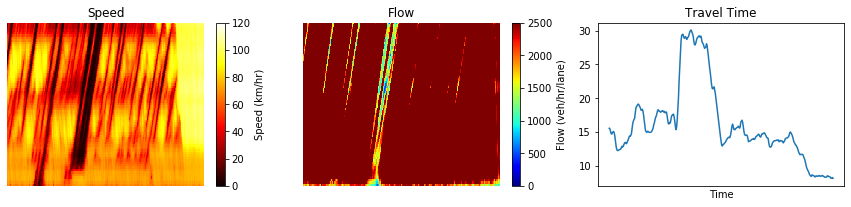

In [2]:
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 0

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

## Task 1 - Data Preprocessing

QUESTION 1: Is the raw travel time sufficient to distinguish between the six classes?
Hint: Use TSNE or LDA

In [3]:
#Code


#Answer

QUESTION 2: The travel time of a day have an aggregation of one minute. Is this time aggregation of the dataset necessary? Or can you aggregate the data further in time for the classification? 

In [4]:
#Code

#Answer

QUESTION 3: Does the aggregated travel time data sufficient to distinguish between the six classes. 

In [5]:
#Code

#Answer

## Bonus Question - High level features

QUESTION 4: Extract high-level features from the travel time dataset using any method or detector. Visualise the output of the detector with an example travel time vector.

In [6]:
#Code

#Answer

QUESTION 5: Is the high-level features sufficient to distinguish between the six classes. 

In [7]:
#Code

#Answer

## Task 2 - Probablistic Classifier

QUESTION 6: Divide the dataset into test, train and validation dataset. Build a logistic classifier for the dataset. Use leave-one-out validation strategy for the classifier. Justify the parameter selection

In [8]:
#Code


#Answer

QUESTION 7: Evaluate the classification results with atleast 2 metrics. Justify your choice of metric.  

In [9]:
#Code

#Answer

QUESTION 8: Comment on the statistics of the probabilities in majority and minority classes

In [10]:
#Code

#Answer

## Task 3 - Random Forest Classifier

QUESTION 9: Build a random forest classifier for the dataset. Use k-fold validation strategy for the classifier

In [11]:
#Code

#Answer

QUESTION 10: Conduct a sensitivity analysis of atleast two parameters of the random forest decision trees. Note: You dont need to find the optimal parameters but should conduct a sensitivity analysis.

In [12]:
#Code

#Answer

QUESTION 11: Analyse one of the pattern that is wrongly classified and explain why you think it is wrongly classified?

In [13]:
#Code

#Answer

## Task 4 - Feature Importance

QUESTION 12: Visualise one of the random tree. Comment on the tree structure

In [14]:
#Code

#Answer

QUESTION 13: Analyse the random forest feature importance and comment on the findings.

In [15]:
#Code

#Answer

## Task 5 - Reflection

QUESTION 14: Given your analysis of the data, do you consider this a supervised classification problem or do you think it can also be solved as a unsupervised learning problem. (No need of coding. Just reflect!)

#Answer